#  <center>Advertiser Digital Ads</center>
***

#### Imports:

In [429]:
import warnings; warnings.filterwarnings("ignore") # dangerous
import math
import mpld3
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.api
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import importlib
importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)
import cachetools, requests, urllib
import os, json, time, math, datetime, dateutil, calendar, itertools
plt.style.use(['classic'])
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_categories', 300)
pd.set_option('display.width', 208)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.memory_usage', True)
pd.set_option('display.precision', 7)
%matplotlib inline
def pctfmt(x, d = 2):
    val = round(100*x, d)
    if d == 0:
        val = int(val)
    return str(val) + '%'
def intfmt(x):
    return format(int(x), ',d')

---
### Colors:

In [577]:
def rgb2hex(rgb):
    rgb = tuple([int(255*x) for x in rgb])
    return '#%02x%02x%02x' % rgb

def gencolors(cmapname = 'viridis', numcolors = 8):
    colortheme = plt.get_cmap(cmapname).colors
    colorlist = list(map(rgb2hex, colortheme))
    nc2 = numcolors//2
    colorset = colorlist[0::len(colorlist)//numcolors]
    colorseta = colorset[:nc2]
    colorsetb = colorset[nc2:]
    colorseq = []
    for i in range(nc2):
        colorseq += [colorseta.pop(0)]
        colorseq += [colorsetb.pop(0)]
    return colorseq

---
## Data Loading:
---

In [2]:
! wc -l data/*.csv

     21508 data/8295_Advertiser_monthly_20160802_215222_271461413.csv
   1297485 data/8295_Advertiser_creativemax4_20160817_133846_277760504.csv
   1429504 data/8295_Advertiser_creativemax4_20160909_142323_286555121.csv
   1324370 data/8295_Advertiser_richmedia_20160817_234515_277759232.csv
   1445095 data/8295_Advertiser_richmedia_20160907_191547_285832929.csv
       143 data/Advertiser_searchtrends_201608.csv
   5518105 total


In [153]:
fn_xl = 'data/Advertiser Monthly Creative Analysis_August.xlsx'
fn_kl = 'data/8295_Advertiser_monthly_20160802_215222_271461413.csv'
fn_cr = 'data/8295_Advertiser_creativemax4_20160909_142323_286555121.csv'
fn_rm = 'data/8295_Advertiser_richmedia_20160907_191547_285832929.csv'

In [17]:
dfkl = pd.read_csv(fn_kl, skiprows = 13, skipfooter = 1, engine = 'python')
dfkl.columns = dfkl.columns.str.lower().str.replace(' ','_').str.replace('-','').str.replace('[-\(\)]','')
dfkl.head(1)

,campaign,campaign_id,site_dcm,placement,creative,activity,month,impressions,clicks,total_conversions,active_view:_measurable_impressions,active_view:_viewable_impressions
0,Advertiser 2016 - F57,9703514,Aki Technologies,aKi|CPM|RON|BT|A40-64|MP|F57_AV_Moments_Smartp...,Advertiser-2919_300x250_Awareness_Defy_Teal.gif,BMW USA - Special Offers - Lease,2016-07,0,0,10,0,0


In [75]:
if True:
    dfcr = pd.read_csv(fn_cr, skiprows = 9, skipfooter = 1, engine = 'python', parse_dates = ['Date'])
    dfcr['Month'] = dfcr.Date.dt.year.astype(str) + '-' + dfcr.Date.dt.month.astype(str)
    dfcr.Impressions = dfcr.Impressions.astype(int)
    dfcr.Clicks = dfcr.Clicks.astype(int)
    dfcr['Click-through Conversions'] = dfcr['Click-through Conversions'].astype(int)
    dfcr['View-through Conversions'] = dfcr['View-through Conversions'].astype(int)
    dfcr['Total Conversions'] = dfcr['Click-through Conversions'] + dfcr['View-through Conversions']
    dfcr.columns = dfcr.columns.str.lower().str.replace(' ','_').str.replace('-','').str.replace('[-\(\)]','')
    dfcr.to_hdf(fn_cr.replace('.csv','.hdf'), key = 'table')
dfcr = pd.read_hdf(fn_cr.replace('.csv','.hdf'), key = 'table')
#dfcr = dfcr[dfcr.campaign.isin(dfkl.campaign.unique())] # Ignoring Mini Next and MTTS
dfcr.reset_index(drop = True, inplace = True)
dfcr.head(2)

,date,site_id_dcm,site_dcm,campaign_id,campaign,campaign_start_date,campaign_end_date,ad_id,ad,ad_type,...,activity_group_id,activity_group,activity_id,activity,impressions,clicks,clickthrough_conversions,viewthrough_conversions,total_conversions,month
0,2015-12-22,1518101,NBCSports.com,9322714,"Advertiser 2016 - NBC ""Men in Blazers"" - Digital Spo...",2016-01-01,2016-05-20,299869826,NBC Sports _300x250_Static,Standard,...,(not set),(not set),(not set),(not set),1,0,0,0,0,2015-12
1,2015-12-22,1518101,NBCSports.com,9322714,"Advertiser 2016 - NBC ""Men in Blazers"" - Digital Spo...",2016-01-01,2016-05-20,299874592,NBC Sports_Video_1x1_Tracking Ad,Tracking,...,269496,TierII,1155705,BMW_DynamicRegional_Handraiser (See Offers),0,0,1,0,1,2015-12


#### Load Rich Media Data:

In [76]:
if True:
    dfrm = pd.read_csv(fn_rm, skiprows = 9, skipfooter = 1, engine = 'python', parse_dates = ['Date'])
    dfrm['Month'] = dfrm.Date.dt.year.astype(str) + '-' + dfrm.Date.dt.month.astype(str)
    dfrm.columns = dfrm.columns.str.lower().str.replace(' ','_').str.replace('-','').str.replace('[-\(\)]','')
    dfrm.to_hdf(fn_rm.replace('.csv','.hdf'), key = 'table')
dfrm = pd.read_hdf(fn_rm.replace('.csv','.hdf'), key = 'table')
#dfrm = dfrm[dfrm.campaign.isin(dfkl.campaign.unique())] # Ignoring Mini Next and MTTS
dfrm.reset_index(drop = True, inplace = True)
dfrm.head(2)

,date,campaign_id,campaign,site_dcm,placement,creative_id,creative,creative_type,rich_media_event,activity_id,...,total_interactions,interactive_impressions,manual_closes,video_completions,video_midpoints,video_mutes,video_plays,video_replays,video_views,month
0,2015-12-22,9322714,"Advertiser 2016 - NBC ""Men in Blazers"" - Digital Spo...",NBCSports.com,NBC Sports||CPM|1x1|ROS|DEMO|||A25-54|VP|Menin...,67946438,Advertiser 2016_MeninBlazersVideo_1x1,Tracking,(not set),1155705,...,0,0,0,0,0,0,0,0,0,2015-12
1,2015-12-22,9322714,"Advertiser 2016 - NBC ""Men in Blazers"" - Digital Spo...",NBCSports.com,NBC Sports||CPM|1x1|ROS|DEMO|||A25-54|VP|Menin...,67946438,Advertiser 2016_MeninBlazersVideo_1x1,Tracking,(not set),(not set),...,0,0,0,0,0,0,0,0,0,2015-12


#### Load Categorization Data From Excel Source:

In [154]:
xl = pd.io.excel.ExcelFile(fn_xl)
print(xl.sheet_names)

['print', 'print_old', 'pivot', 'pivot_creative comparison', 'joel', 'creatives', 'lkup_plc', 'lkup_act', 'lkup_act2', 'lkup_cr', 'checks', 'benchmarks', 'Sheet1', 'dfa', 'richmedia']


In [155]:
dfplc_cat = xl.parse('lkup_plc')
dfplc_cat = dfplc_cat.where((pd.notnull(dfplc_cat)), '')
dfplc_cat.columns = dfplc_cat.columns.str.lower().str.replace(' ','_')
dfplc_cat.placements = dfplc_cat.placements.str.strip()
dfplc_cat.head(2)

,placements,exchange,placement_type,funnel_type,fbx_creative
0,aKi|CPM|RON|BT|A40-64|MP|F57_AV_Moments_Smartp...,,,Awareness,
1,aKi|CPM|RON|BT|A40-64|MP|F57_AV_Moments_Smartp...,,,Awareness,


In [156]:
dfcr_cat = xl.parse('lkup_cr')
dfcr_cat = dfcr_cat.where((pd.notnull(dfcr_cat)), '')
dfcr_cat.columns = dfcr_cat.columns.str.lower().str.replace(' ','_')
dfcr_cat.drop_duplicates(['creative_name'], keep = 'last', inplace = True)
dfcr_cat.head(2)

,creative_name,creative_type,creative_size
0,1x1_NBC_WebsiteSkin,MIB,1x1
2,Advertiser-2798_HPTO_300x250.gif,MIB,300x250


In [157]:
dfact_cat = xl.parse('lkup_act')
dfact_cat.columns = ('activity','act_type1','act_type2','act_type3','act_type4')
dfact_cat = dfact_cat.where((pd.notnull(dfact_cat)), '')
dfact_cat.head(2)

,activity,act_type1,act_type2,act_type3,act_type4
0,(not set),,,,
1,3 Series- Contact Dealer Lead Mobile - Page Load,BMW,,,


---
## Categorization Maps:

In [158]:
def categorize_acttypes(adf):
    adf['lead'] = adf.apply(lambda x: x.total_conversions if x.act_type1.lower() == 'lead' else 0, axis = 1)
    adf['handraiser'] = adf.apply(lambda x: x.total_conversions if x.act_type1.lower() == 'handraiser' else 0, axis = 1)
    adf['lp_f54'] = adf.apply(lambda x: x.total_conversions if x.act_type1.lower() == 'landing page f54' else 0, axis = 1)
    adf['lp_f57'] = adf.apply(lambda x: x.total_conversions if x.act_type1.lower() == 'landing page f57' else 0, axis = 1)
    adf['lp_r60'] = adf.apply(lambda x: x.total_conversions if x.act_type1.lower() == 'landing page r60' else 0, axis = 1)
    adf['model'] = adf.apply(lambda x: x.total_conversions if x.act_type2.lower() == 'model' else 0, axis = 1)
    return adf

---
## Data Merge:
---

#### Digi Display Merge:

In [159]:
dg = dfcr.merge(dfplc_cat, left_on = 'placement', right_on = 'placements', how = 'left')
dg = dg.merge(dfcr_cat, left_on = 'creative', right_on = 'creative_name', how = 'left', suffixes=('_dfa', ''))
dg = dg.merge(dfact_cat, left_on = 'activity', right_on = 'activity', how = 'left')
dg = dg.where((pd.notnull(dg)), '')
dg = categorize_acttypes(dg)
print((dfcr.shape[0], dg.shape[0]))
assert dfcr.shape[0] == dg.shape[0]

(1429493, 1429493)


In [160]:
dg.head(2)

,date,site_id_dcm,site_dcm,campaign_id,campaign,campaign_start_date,campaign_end_date,ad_id,ad,ad_type,...,act_type1,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model
0,2015-12-22,1518101,NBCSports.com,9322714,"Advertiser 2016 - NBC ""Men in Blazers"" - Digital Spo...",2016-01-01,2016-05-20,299869826,NBC Sports _300x250_Static,Standard,...,,,,,0,0,0,0,0,0
1,2015-12-22,1518101,NBCSports.com,9322714,"Advertiser 2016 - NBC ""Men in Blazers"" - Digital Spo...",2016-01-01,2016-05-20,299874592,NBC Sports_Video_1x1_Tracking Ad,Tracking,...,BMW,,,,0,0,0,0,0,0


#### Rich Media Merge:

In [161]:
dgrm = dfrm.merge(dfplc_cat, left_on = 'placement', right_on = 'placements', how = 'left')
dgrm = dgrm.merge(dfcr_cat, left_on = 'creative', right_on = 'creative_name', how = 'left', suffixes=('_dfa', ''))
dgrm = dgrm.merge(dfact_cat, left_on = 'activity', right_on = 'activity', how = 'left')
dgrm = dgrm.where((pd.notnull(dgrm)), '')
dgrm = categorize_acttypes(dgrm)
print((dgrm.shape[0], dgrm.shape[0]))
assert dgrm.shape[0] == dgrm.shape[0]

(1445084, 1445084)


In [162]:
dgrm.head(2)

,date,campaign_id,campaign,site_dcm,placement,creative_id,creative,creative_type_dfa,rich_media_event,activity_id,...,act_type1,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model
0,2015-12-22,9322714,"Advertiser 2016 - NBC ""Men in Blazers"" - Digital Spo...",NBCSports.com,NBC Sports||CPM|1x1|ROS|DEMO|||A25-54|VP|Menin...,67946438,Advertiser 2016_MeninBlazersVideo_1x1,Tracking,(not set),1155705,...,BMW,,,,0,0,0,0,0,0
1,2015-12-22,9322714,"Advertiser 2016 - NBC ""Men in Blazers"" - Digital Spo...",NBCSports.com,NBC Sports||CPM|1x1|ROS|DEMO|||A25-54|VP|Menin...,67946438,Advertiser 2016_MeninBlazersVideo_1x1,Tracking,(not set),(not set),...,,,,,0,0,0,0,0,0


---
## Funnel Stage Groupings:
---

In [193]:
dgsl.pivot_table(index = ['campaign','funnel_type'],
                values = ['impressions','clicks','total_conversions'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 0')

clicks  impressions  \
campaign                   funnel_type                          
Advertiser 2016- Tier 2 Olympics Consideration  113873     59121407   
                           Awareness       84521     44836037   
                           Purchase        48202     21664303   

                                          total_conversions  
campaign                   funnel_type                       
Advertiser 2016- Tier 2 Olympics Consideration             218593  
                           Awareness                  56978  
                           Purchase                  376881

In [194]:
dgsl.pivot_table(index = ['funnel_type'],
                values = ['impressions','total_conversions'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 0')

,impressions,total_conversions
funnel_type,,
Consideration,59121407,218593
Awareness,44836037,56978
Purchase,21664303,376881


In [197]:
dgsl.head()

,date,site_id_dcm,site_dcm,campaign_id,campaign,campaign_start_date,campaign_end_date,ad_id,ad,ad_type,package/roadblock_id,package/roadblock,package/roadblock_strategy,package/roadblock_total_booked_units,placement_id,placement,placement_strategy,placement_cost_structure,placement_start_date,placement_end_date,placement_pixel_size,creative_groups_1,creative_groups_2,creative_id,creative,creative_type_dfa,creative_pixel_size,clickthrough_url,content_category,activity_group_id,activity_group,activity_id,activity,impressions,clicks,clickthrough_conversions,viewthrough_conversions,total_conversions,month,placements,exchange,placement_type,funnel_type,fbx_creative,creative_name,creative_type,creative_size,act_type1,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model
1213964,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),269397,Main,1154930,BMWUSA_Homepage,0,0,0,1,1,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,BMW,,,,0,0,0,0,0,0
1213965,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),269397,Main,1154931,BMW_DynamicNational_Shopper,0,0,0,1,1,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,BMW,,,,0,0,0,0,0,0
1213966,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),1283227,Shopper,3625579,BMWUSA - Shopper_PL,0,0,0,2,2,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,other,,,,0,0,0,0,0,0
1213967,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),1360304,Advertiser Defy Labels,3712778,Advertiser USA Defy Labels Olympics Offer T2 Homepage,0,0,2,0,2,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,,,,,0,0,0,0,0,0
1213968,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(no

In [198]:
dgsl.pivot_table(index = ['funnel_type','creative_type'],
                values = ['impressions','total_conversions'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 0')

impressions  total_conversions
funnel_type   creative_type                                               
Consideration Google                           23875547             150829
              Olympics Tier 2 Silver Rear      23662243              50840
Awareness     Olympics Tier 2 Silver           18149317              19246
              Olympics Tier 2 Silver Rear      14432478              28100
Purchase      Google                            8904057             223250
Awareness     Olympics Tier 2                   6681249                833
Purchase      Olympics Tier 2 Silver Rear       6671370              95536
Consideration Olympics Tier 2 Silver Grill      5833939              11223
              Olympics Tier 2 Silver            4115184               3897
Purchase      Olympics Tier 2 Silver Grill      3116601              38642
Awareness     Olympics Tier 2 Silver Grill      2824706               5483
              FBX                               2748259               3315
Purchase      Olympics Tier 2 Silver            1664560               3930
Consideration FBX                               1511391               1298
Purchase      FBX                               1307714              15521
Consideration Olympics Tier 1 Blue               123099                506
Awareness     Olympics Tier 1 Blue                   25                  1
Consideration Olympics Tier 2                         4                  0
Awareness     Olympics Tier 2 Athlete                 3                  0
Purchase      Olympics Tier 1 Blue                    1                  0

In [199]:
def barlabel_h(rects, axis, font_size = 14):
    maxwid = 0
    for r in rects:
        maxwid_tmp = r.get_width()
        if maxwid_tmp > maxwid:
            maxwid = maxwid_tmp
    for r in rects:
        w, h = r.get_width(), r.get_height()
        x, y = r.get_x(), r.get_y()
        axis.text(min(x + w + maxwid * 0.09, maxwid*1.08), y + h/2.14, '{0:.2}%'.format(w), ha='center', va='bottom', fontsize = font_size)

def fatlabels(axis, font_size = 14):
    for item in ([axis.xaxis.label, axis.yaxis.label] + axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(font_size)

In [204]:
dgsl.pivot_table(index = ['site_dcm','funnel_type'],
                values = ['impressions','total_conversions'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 0')

impressions  total_conversions
site_dcm         funnel_type                                  
Cadreon          Consideration     30689817              63249
xAd              Awareness         26682233              21624
Google - YouTube Consideration     23875547             150829
Cadreon          Awareness         18153804              35354
                 Purchase          12760246             153631
Google - YouTube Purchase           8904057             223250
xAd              Consideration      4556043               4515

In [267]:
dgsl.head(2)

,date,site_id_dcm,site_dcm,campaign_id,campaign,campaign_start_date,campaign_end_date,ad_id,ad,ad_type,package/roadblock_id,package/roadblock,package/roadblock_strategy,package/roadblock_total_booked_units,placement_id,placement,placement_strategy,placement_cost_structure,placement_start_date,placement_end_date,placement_pixel_size,creative_groups_1,creative_groups_2,creative_id,creative,creative_type_dfa,creative_pixel_size,clickthrough_url,content_category,activity_group_id,activity_group,activity_id,activity,impressions,clicks,clickthrough_conversions,viewthrough_conversions,total_conversions,month,placements,exchange,placement_type,funnel_type,fbx_creative,creative_name,creative_type,creative_size,act_type1,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model
1213964,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),269397,Main,1154930,BMWUSA_Homepage,0,0,0,1,1,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,BMW,,,,0,0,0,0,0,0
1213965,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),269397,Main,1154931,BMW_DynamicNational_Shopper,0,0,0,1,1,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,BMW,,,,0,0,0,0,0,0


---
## KPI Rate Bar Plots:
---

In [681]:
def barateplot(funnel = 'Purchase', site = 'Cadreon', kpi = 'handraiser',
               goal = 0.000017, invert_goal = False, goal_shift = 0.2, logaxes = True):
    # Data Slice:
    filter_str = 'funnel_type == "%s" and site_dcm == "%s" and (creative_pixel_size == "300x250" or creative_pixel_size == "728x90") and date >= "2016-08-19"'
    dfplt = dgsl.query(filter_str % (funnel, site))
    dfplt = dfplt[['creative_type','impressions',kpi]].groupby('creative_type').sum()
    dfplt['kpi'] = (dfplt[kpi] / dfplt.impressions).fillna(0)
    dfplt.sort_values('kpi', inplace = True)
    dfplt.reset_index(inplace = True)
    # Plot:
    fig, ax = plt.subplots(1, 1, figsize = (10,6))
    if goal and invert_goal:
        goalmark = goal * goal_shift
    elif goal:
        goalmark = (1 + goal_shift) * goal
    if goal:
        ax.text(goalmark, 0.6, 'Goal: ' + pctfmt(goal,4), fontsize = 18)
        plt.axvline(x = goal, lw = 2, ls = '--', c = 'black')
    wid = 0.5
    cols = dfplt.shape[0]
    ind = np.arange(1,cols+1)
    ax.barh(ind, dfplt['kpi'], wid, label = dfplt.creative_type, color = '#005073')
    ax.set_title('KPI: %s Rate %s' % (kpi.title(), site.title()[:18]), fontsize = 24)
    if logaxes:
        ax.set_xscale('log')
    ax.grid(which = 'both')
    ax.set(yticks = ind + wid/2, yticklabels = dfplt.creative_type, ylim = (1-wid, cols+2*wid))
    fatlabels(ax, font_size = 20)
    plt.tight_layout()
    plt.savefig('charts/Advertiser_creative_%s_%s_%s.eps' % (funnel, site.replace(' ','').replace('-',''), kpi))
    plt.show()

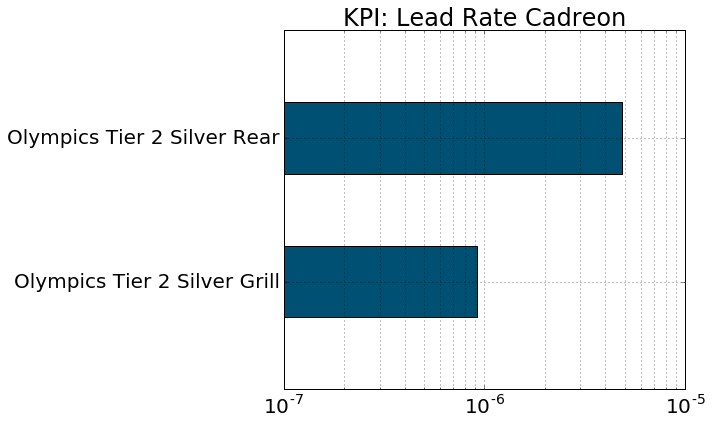

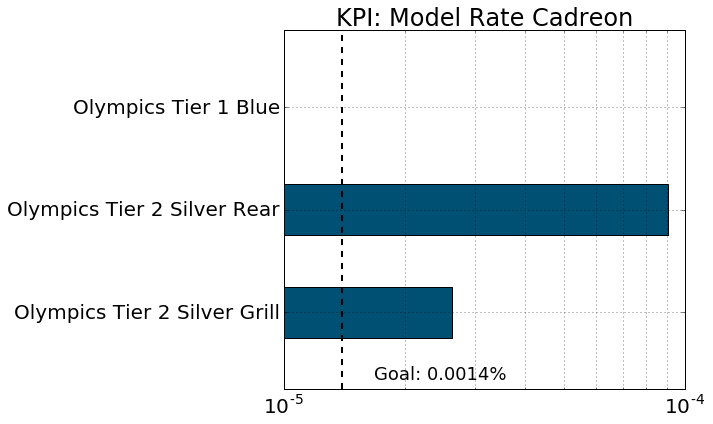

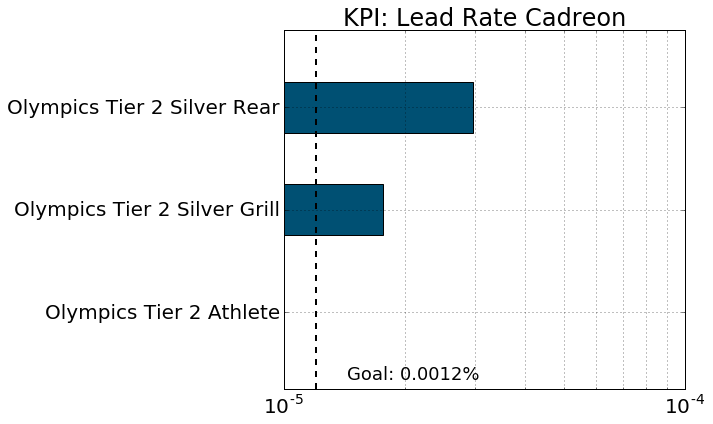

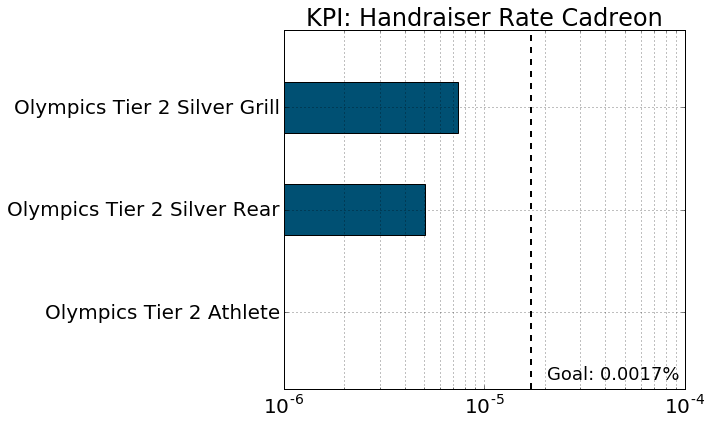

In [682]:
barateplot(funnel = 'Awareness', kpi = 'lead', goal = None)
barateplot(funnel = 'Consideration', kpi = 'model', goal = 0.000014)
barateplot(funnel = 'Purchase', kpi = 'lead', goal = 0.000012)
barateplot(funnel = 'Purchase', kpi = 'handraiser', goal = 0.000017)

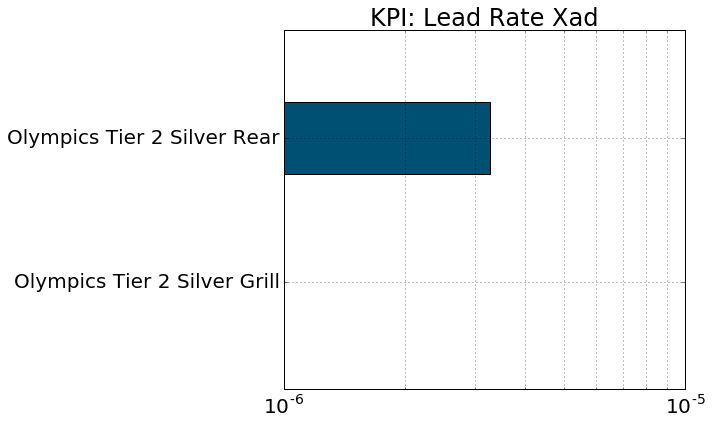

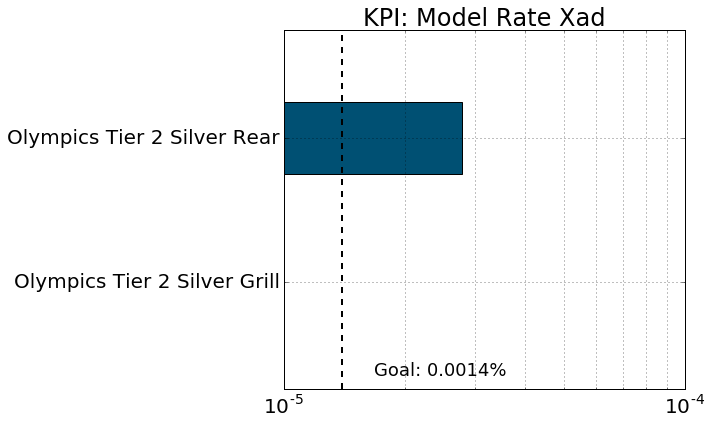

In [683]:
barateplot(funnel = 'Awareness', site = 'xAd', kpi = 'lead', goal = None)
barateplot(funnel = 'Consideration', site = 'xAd', kpi = 'model', goal = 0.000014)

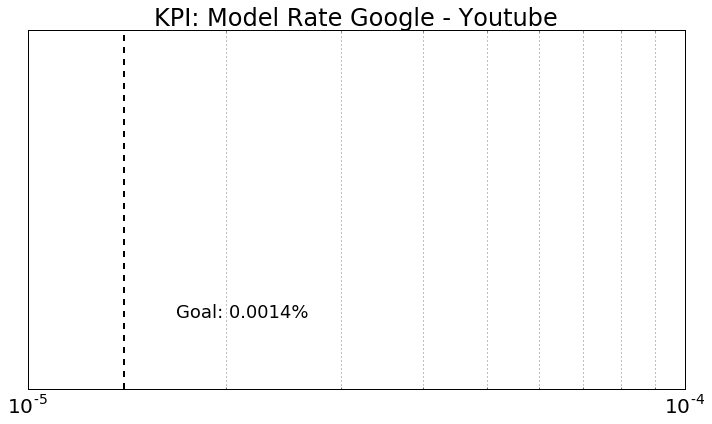

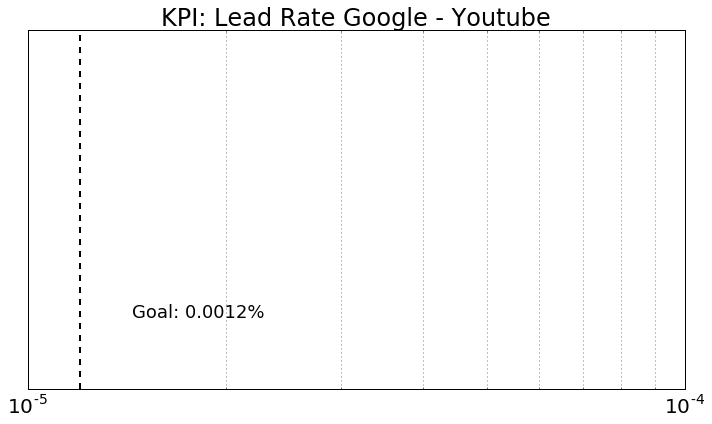

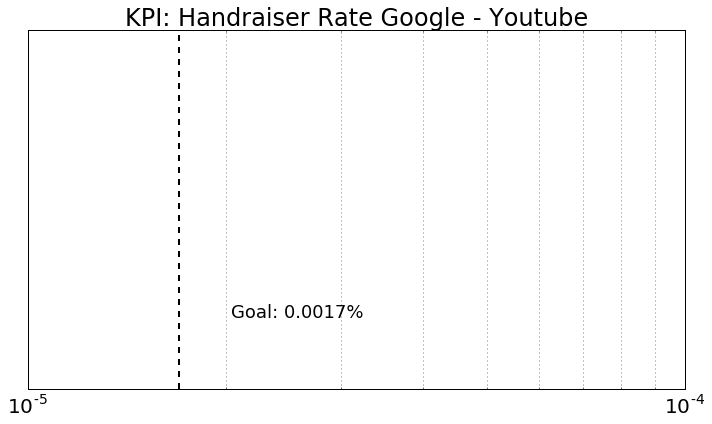

In [684]:
barateplot(funnel = 'Consideration', site = 'Google - YouTube', kpi = 'model', goal = 0.000014)
barateplot(funnel = 'Purchase', site = 'Google - YouTube', kpi = 'lead', goal = 0.000012)
barateplot(funnel = 'Purchase', site = 'Google - YouTube', kpi = 'handraiser', goal = 0.000017)

---
## Creative Size review:
---

In [491]:
crszsl = dgsl[dg.site_dcm == 'Cadreon'].pivot_table(index = ['creative_size'],
                values = ['impressions','landing_pages','model','lead','handraiser'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 0')
crszsl.reset_index(inplace = True)
crszsl = crszsl[crszsl.creative_size != '1x1']
crszsl['landingpage_rate'] = crszsl.landing_pages / crszsl.impressions
crszsl['model_rate'] = crszsl.model / crszsl.impressions
crszsl['lead_rate'] = crszsl.lead / crszsl.impressions
crszsl['handraiser_rate'] = crszsl.handraiser / crszsl.impressions
crszsl

,creative_size,handraiser,impressions,landing_pages,lead,model,landingpage_rate,model_rate,lead_rate,handraiser_rate
0,300x250,43,31753177,3169,227,5669,0.0000998,0.0001785,0.0000071,0.0000014
1,728x90,24,17306930,1503,60,2826,0.0000868,0.0001633,0.0000035,0.0000014
3,160x600,5,3154890,375,24,695,0.0001189,0.0002203,0.0000076,0.0000016
4,300x600,7,2156946,331,26,600,0.0001535,0.0002782,0.0000121,0.0000032
5,320x50,0,1438616,4,0,9,0.0000028,0.0000063,0.0000000,0.0000000
6,300x50,0,225944,126,20,227,0.0005577,0.0010047,0.0000885,0.0000000


---
## Cash Back Offer Performance:
---

In [499]:
dgsl.head(3)

,date,site_id_dcm,site_dcm,campaign_id,campaign,campaign_start_date,campaign_end_date,ad_id,ad,ad_type,package/roadblock_id,package/roadblock,package/roadblock_strategy,package/roadblock_total_booked_units,placement_id,placement,placement_strategy,placement_cost_structure,placement_start_date,placement_end_date,placement_pixel_size,creative_groups_1,creative_groups_2,creative_id,creative,creative_type_dfa,creative_pixel_size,clickthrough_url,content_category,activity_group_id,activity_group,activity_id,activity,impressions,clicks,clickthrough_conversions,viewthrough_conversions,total_conversions,month,placements,exchange,placement_type,funnel_type,fbx_creative,creative_name,creative_type,creative_size,act_type1,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model,landing_pages
1213964,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),269397,Main,1154930,BMWUSA_Homepage,0,0,0,1,1,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,BMW,,,,0,0,0,0,0,0,0
1213965,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),269397,Main,1154931,BMW_DynamicNational_Shopper,0,0,0,1,1,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,BMW,,,,0,0,0,0,0,0,0
1213966,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),1283227,Shopper,3625579,BMWUSA - Shopper_PL,0,0,0,2,2,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,other,,,,0,0,0,0,0,0,0


In [501]:
dgsl.creative.unique()

array(['AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF',
       'AdvertiserD-0499_Olympics_Tier2_Blue-300x600_1000.GIF',
       'AdvertiserD-0499_Olympics_Tier2_BlueCar-300x600.gif_Test S (copy)',
       'AdvertiserD-0499_Olympics_Tier2_Blue-300x250_1000.GIF',
       'AdvertiserD-0499_Olympics_Tier2_Blue-728x90_1000.GIF',
       'AdvertiserD-0499_Olympics_Tier2_BlueCar-728x90.gif_Test S (copy)',
       'AdvertiserD-0499_Olympics_Tier2_Athlete-300x250.gif_Test S (copy)',
       'AdvertiserD-0499_Olympics_Tier2_BlueCar-300x250.gif_Test S (copy)',
       'AdvertiserD-0499_Olympics_Tier2_320x50_Athlete_V2',
       'AdvertiserD-0499_Olympics_Tier1_Blue_320x50.jpg',
       'AdvertiserD-0499_Olympics_Tier2_Silver-160x600_CashOff_Rear.gif',
       'AdvertiserD-0499_Olympics_Tier2_Silver-300x600_CashOff_Rear.gif',
       'AdvertiserD-0499_Olympics_Tier2_Silver-300x250_CashOff_Rear.gif',
       'AdvertiserD-0499_Olympics_Tier2_Silver-728x90_CashOff_Rear.gif',
       'AdvertiserD-0499_Olym

In [525]:
dgsl.head(1)

,date,site_id_dcm,site_dcm,campaign_id,campaign,campaign_start_date,campaign_end_date,ad_id,ad,ad_type,package/roadblock_id,package/roadblock,package/roadblock_strategy,package/roadblock_total_booked_units,placement_id,placement,placement_strategy,placement_cost_structure,placement_start_date,placement_end_date,placement_pixel_size,creative_groups_1,creative_groups_2,creative_id,creative,creative_type_dfa,creative_pixel_size,clickthrough_url,content_category,activity_group_id,activity_group,activity_id,activity,impressions,clicks,clickthrough_conversions,viewthrough_conversions,total_conversions,month,placements,exchange,placement_type,funnel_type,fbx_creative,creative_name,creative_type,creative_size,act_type1,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model,landing_pages
1213964,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),269397,Main,1154930,BMWUSA_Homepage,0,0,0,1,1,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,BMW,,,,0,0,0,0,0,0,0


---
## Creative Spotlight August:
---

In [638]:
dgsl.head(2)

,date,site_id_dcm,site_dcm,campaign_id,campaign,campaign_start_date,campaign_end_date,ad_id,ad,ad_type,package/roadblock_id,package/roadblock,package/roadblock_strategy,package/roadblock_total_booked_units,placement_id,placement,placement_strategy,placement_cost_structure,placement_start_date,placement_end_date,placement_pixel_size,creative_groups_1,creative_groups_2,creative_id,creative,creative_type_dfa,creative_pixel_size,clickthrough_url,content_category,activity_group_id,activity_group,activity_id,activity,impressions,clicks,clickthrough_conversions,viewthrough_conversions,total_conversions,month,placements,exchange,placement_type,funnel_type,fbx_creative,creative_name,creative_type,creative_size,act_type1,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model,landing_pages
1213964,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),269397,Main,1154930,BMWUSA_Homepage,0,0,0,1,1,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,BMW,,,,0,0,0,0,0,0,0
1213965,2016-08-01,1367309,Cadreon,10133259,Advertiser 2016- Tier 2 Olympics,2016-08-01,2016-09-30,308577129,Cadreon_160x600_HTML5,Standard,136003350,Cadreon|CPM|ROS|DEMO|A25-54|NT|Contextual_PKG,(not set),7000000,136001794,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,(not set),CPM,2016-08-01,2016-09-30,160 x 600,(not set),(not set),73207089,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Display,160x600,(not set),(not set),269397,Main,1154931,BMW_DynamicNational_Shopper,0,0,0,1,1,2016-8,Cadreon|CPM|ROS|DEMO|A25-54|FT|Contextual_160x...,,Contextual & PMP,Consideration,,AdvertiserD-0499_Olympics_Tier2_Blue-160x600_1000.GIF,Olympics Tier 1 Blue,160x600,BMW,,,,0,0,0,0,0,0,0


In [664]:
dgsl.creative_pixel_size.value_counts()

300x250    17356
0x0        16803
728x90     12269
160x600     5575
300x600     4463
320x50      2380
300x50       816
Name: creative_pixel_size, dtype: int64

In [673]:
dgsl.query('creative_type == "Olympics Tier 2 Silver Rear"').date.describe()

count                   28690
unique                     30
top       2016-08-19 00:00:00
freq                     1262
first     2016-08-02 00:00:00
last      2016-08-31 00:00:00
Name: date, dtype: object

In [674]:
dgsl.query('creative_type == "Olympics Tier 2 Silver Grill"').date.describe()

count                   10686
unique                     13
top       2016-08-30 00:00:00
freq                      986
first     2016-08-19 00:00:00
last      2016-08-31 00:00:00
Name: date, dtype: object

In [675]:
dfplt = dgsl.copy()
dfplt = dfplt.query('site_dcm == "Cadreon" and (creative_pixel_size == "300x250" or creative_pixel_size == "728x90") and date >= "2016-08-19"')
dfplt = dfplt[~dfplt.creative.str.contains('1x1')]
dfplt = dfplt.pivot_table(index = ['creative_type'],#['site_dcm','funnel_type','placement_type','creative_type'],
                values = ['impressions','clicks','landing_pages','model','lead','handraiser'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 1000').reset_index()

In [676]:
dfplt['click_rate'] = dfplt.clicks / dfplt.impressions
dfplt['landingpage_rate'] = dfplt.landing_pages / dfplt.impressions
dfplt['model_rate'] = dfplt.model / dfplt.impressions
dfplt['lead_rate'] = dfplt.lead / dfplt.impressions
dfplt['handraiser_rate'] = dfplt.handraiser / dfplt.impressions
dfplt.style.bar(color = '#99ff33')

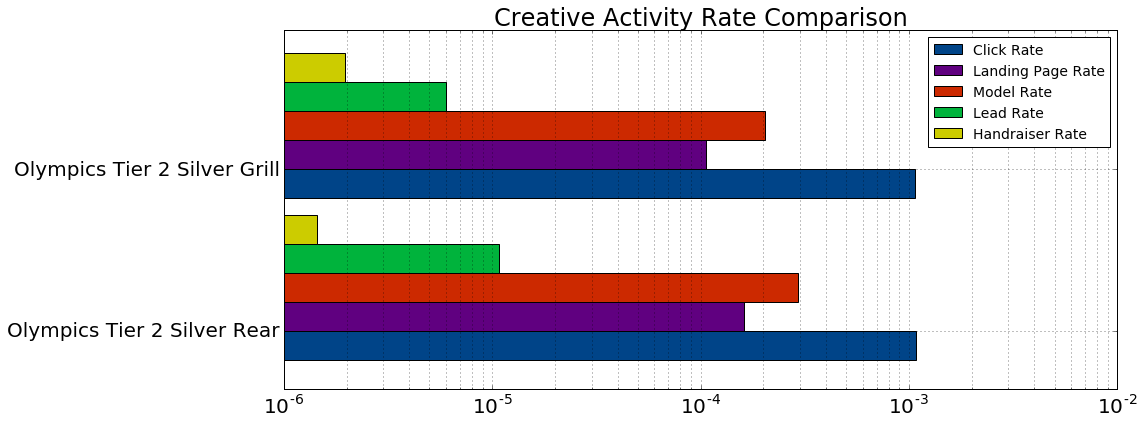

In [680]:
fig, ax = plt.subplots(1, 1, figsize = (16,6))
wid = 0.36
ind = np.arange(1,2*len(dfplt)+1,2)
ax.barh(ind, dfplt.click_rate, wid, label = 'Click Rate', color = '#004488')
ax.barh(ind+wid, dfplt.landingpage_rate, wid, label = 'Landing Page Rate', color = '#600080')
ax.barh(ind+2*wid, dfplt.model_rate, wid, label = 'Model Rate', color = '#cc2900')
ax.barh(ind+3*wid, dfplt.lead_rate, wid, label = 'Lead Rate', color = '#00b33c')
ax.barh(ind+4*wid, dfplt.handraiser_rate, wid, label = 'Handraiser Rate', color = '#cccc00')
yticklabs = dfplt.creative_type
ax.set(yticks = ind + wid, yticklabels = yticklabs, ylim = (1-wid, 2*len(dfplt)+3*wid))
#ax.legend(loc='upper center', fontsize = 14, ncol = 3)
ax.legend(loc='upper right', fontsize = 14, ncol = 1)
fatlabels(ax, font_size = 20)
ax.set_xscale('log')
ax.grid(which = 'both')
ax.set_title('Creative Activity Rate Comparison', fontsize = 24)
plt.tight_layout();
plt.savefig('charts/Advertiser_creative_spotlight.eps')

---
## Cash Back Offer:
---

In [ ]:
dfplt = dgsl.copy()
dfplt['creative_type2'] = dfplt.creative.apply(crtype2)

In [623]:
def crtype2(cr):
    crt2 = cr
    if 'CashOff' in cr:
        crt2 = 'CashOff_2k'
    elif '1000' in cr:
        crt2 = 'CashOff_1k'
    elif 'Test S' in cr:
        crt2 = 'CashOff_1.5k'
    return crt2

dfplt = dgsl.copy()
dfplt = dgsl[dgsl.site_dcm == 'Cadreon'].copy()
dfplt = dfplt.query('funnel_type == "Consideration" and placement_type == "Contextual & PMP"')
dfplt['creative_type2'] = dfplt.creative.apply(crtype2)
dfplt = dfplt[~dfplt.creative_type2.str.contains('1x1')]
dfplt = dfplt.pivot_table(index = ['site_dcm','funnel_type','placement_type','creative_type','creative_type2'],
                values = ['impressions','clicks','landing_pages','model','lead','handraiser'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 1000').reset_index()

In [624]:
dfplt['click_rate'] = dfplt.clicks / dfplt.impressions
dfplt['landingpage_rate'] = dfplt.landing_pages / dfplt.impressions
dfplt['model_rate'] = dfplt.model / dfplt.impressions
dfplt['lead_rate'] = dfplt.lead / dfplt.impressions
dfplt['handraiser_rate'] = dfplt.handraiser / dfplt.impressions
dfplt.style.bar(color = '#99ff33')

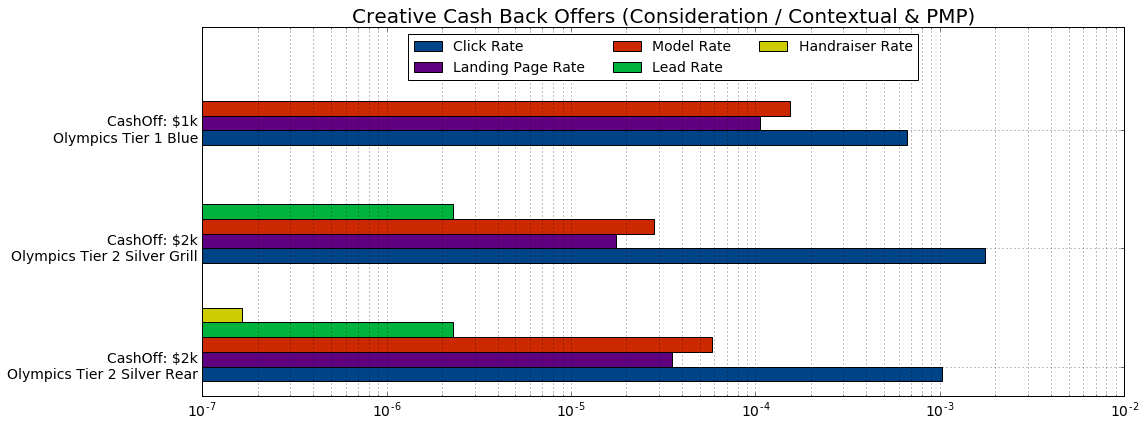

In [625]:
fig, ax = plt.subplots(1, 1, figsize = (16,6))
wid = 0.25
ind = np.arange(1,2*len(dfplt)+1,2)
ax.barh(ind, dfplt.click_rate, wid, label = 'Click Rate', color = '#004488')
ax.barh(ind+wid, dfplt.landingpage_rate, wid, label = 'Landing Page Rate', color = '#600080')
ax.barh(ind+2*wid, dfplt.model_rate, wid, label = 'Model Rate', color = '#cc2900')
ax.barh(ind+3*wid, dfplt.lead_rate, wid, label = 'Lead Rate', color = '#00b33c')
ax.barh(ind+4*wid, dfplt.handraiser_rate, wid, label = 'Handraiser Rate', color = '#cccc00')
yticklabs = dfplt.creative_type2.str.replace('_',': $') + '\n' + dfplt.creative_type
ax.set(yticks = ind + wid, yticklabels = yticklabs, ylim = (1-wid, 2*len(dfplt)+4*wid))
ax.legend(loc='upper center', fontsize = 14, ncol = 3)
fatlabels(ax)
ax.set_xscale('log')
ax.grid(which = 'both')
ax.set_title('Creative Cash Back Offers (Consideration / Contextual & PMP)', fontsize = 20)
plt.tight_layout();
plt.savefig('charts/Advertiser_creative_consideration_cashback.eps')

In [626]:
def crtype2(cr):
    crt2 = cr
    if 'CashOff' in cr:
        crt2 = 'CashOff_2k'
    elif '1000' in cr:
        crt2 = 'CashOff_1k'
    elif 'Test S' in cr:
        crt2 = 'CashOff_1.5k'
    return crt2

dfplt = dgsl.copy()
dfplt = dgsl[dgsl.site_dcm == 'Cadreon'].copy()
dfplt = dfplt.query('funnel_type == "Awareness" and placement_type == "Prospecting"')
dfplt['creative_type2'] = dfplt.creative.apply(crtype2)
dfplt = dfplt[~dfplt.creative_type2.str.contains('1x1')]
dfplt = dfplt.pivot_table(index = ['site_dcm','funnel_type','placement_type','creative_type','creative_type2'],
                values = ['impressions','clicks','landing_pages','model','lead','handraiser'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 1000').reset_index()

In [627]:
dfplt.head(2)

,site_dcm,funnel_type,placement_type,creative_type,creative_type2,clicks,handraiser,impressions,landing_pages,lead,model
0,Cadreon,Awareness,Prospecting,Olympics Tier 2 Silver Rear,CashOff_2k,8140,0,12866800,244,29,425
1,Cadreon,Awareness,Prospecting,Olympics Tier 2 Silver Grill,CashOff_2k,962,0,2538745,41,3,79


In [628]:
dfplt['click_rate'] = dfplt.clicks / dfplt.impressions
dfplt['landingpage_rate'] = dfplt.landing_pages / dfplt.impressions
dfplt['model_rate'] = dfplt.model / dfplt.impressions
dfplt['lead_rate'] = dfplt.lead / dfplt.impressions
dfplt['handraiser_rate'] = dfplt.handraiser / dfplt.impressions
dfplt.style.bar(color = '#99ff33')

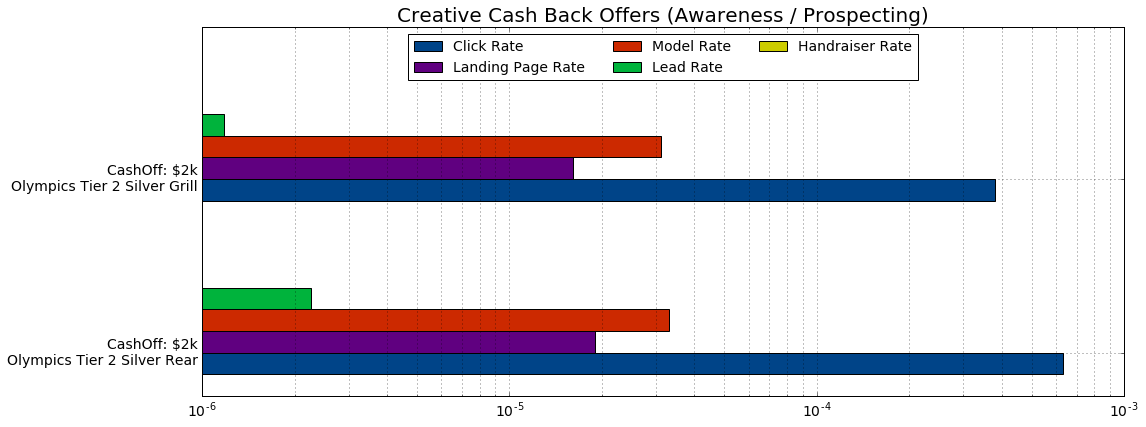

In [629]:
fig, ax = plt.subplots(1, 1, figsize = (16,6))
wid = 0.25
ind = np.arange(1,2*len(dfplt)+1,2)
ax.barh(ind, dfplt.click_rate, wid, label = 'Click Rate', color = '#004488')
ax.barh(ind+wid, dfplt.landingpage_rate, wid, label = 'Landing Page Rate', color = '#600080')
ax.barh(ind+2*wid, dfplt.model_rate, wid, label = 'Model Rate', color = '#cc2900')
ax.barh(ind+3*wid, dfplt.lead_rate, wid, label = 'Lead Rate', color = '#00b33c')
ax.barh(ind+4*wid, dfplt.handraiser_rate, wid, label = 'Handraiser Rate', color = '#cccc00')
yticklabs = dfplt.creative_type2.str.replace('_',': $') + '\n' + dfplt.creative_type
ax.set(yticks = ind + wid, yticklabels = yticklabs, ylim = (1-wid, 2*len(dfplt)+4*wid))
ax.legend(loc='upper center', fontsize = 14, ncol = 3)
fatlabels(ax)
ax.set_xscale('log')
ax.grid(which = 'both')
ax.set_title('Creative Cash Back Offers (Awareness / Prospecting)', fontsize = 20)
plt.tight_layout();
plt.savefig('charts/Advertiser_creative_awareness_cashback.eps')

In [630]:
def crtype2(cr):
    crt2 = cr
    if 'CashOff' in cr:
        crt2 = 'CashOff_2k'
    elif '1000' in cr:
        crt2 = 'CashOff_1k'
    elif 'Test S' in cr:
        crt2 = 'CashOff_1.5k'
    return crt2

dfplt = dgsl.copy()
dfplt = dgsl[dgsl.site_dcm == 'Cadreon'].copy()
dfplt = dfplt.query('funnel_type == "Purchase" and placement_type == "Retargeting"')
dfplt['creative_type2'] = dfplt.creative.apply(crtype2)
dfplt = dfplt[~dfplt.creative_type2.str.contains('1x1')]
dfplt = dfplt.pivot_table(index = ['site_dcm','funnel_type','placement_type','creative_type','creative_type2'],
                values = ['impressions','clicks','landing_pages','model','lead','handraiser'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 1000').reset_index()

In [631]:
dfplt.head(2)

,site_dcm,funnel_type,placement_type,creative_type,creative_type2,clicks,handraiser,impressions,landing_pages,lead,model
0,Cadreon,Purchase,Retargeting,Olympics Tier 2 Silver Rear,CashOff_2k,1742,28,2816343,1131,56,2164
1,Cadreon,Purchase,Retargeting,Olympics Tier 2 Silver,CashOff_2k,2624,0,1664560,130,20,236


In [632]:
dfplt['click_rate'] = dfplt.clicks / dfplt.impressions
dfplt['landingpage_rate'] = dfplt.landing_pages / dfplt.impressions
dfplt['model_rate'] = dfplt.model / dfplt.impressions
dfplt['lead_rate'] = dfplt.lead / dfplt.impressions
dfplt['handraiser_rate'] = dfplt.handraiser / dfplt.impressions
dfplt.style.bar(color = '#99ff33')

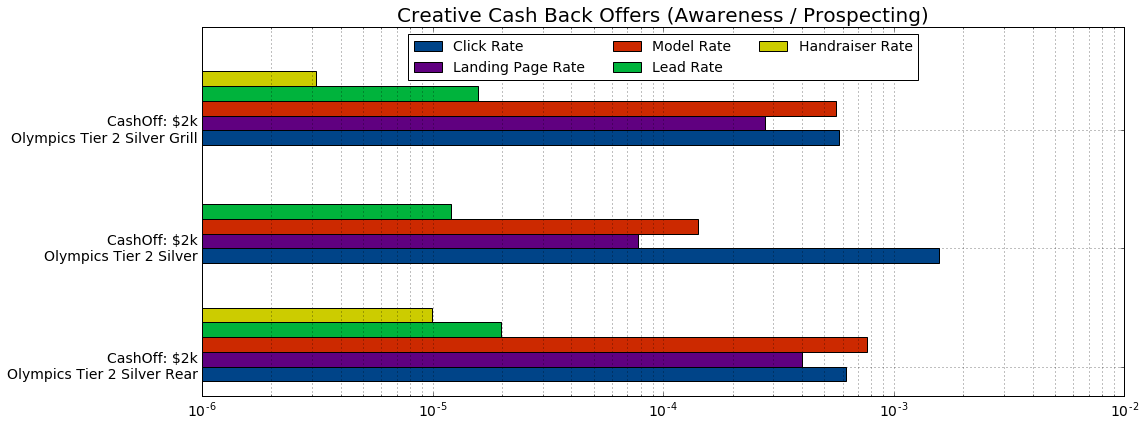

In [633]:
fig, ax = plt.subplots(1, 1, figsize = (16,6))
wid = 0.25
ind = np.arange(1,2*len(dfplt)+1,2)
ax.barh(ind, dfplt.click_rate, wid, label = 'Click Rate', color = '#004488')
ax.barh(ind+wid, dfplt.landingpage_rate, wid, label = 'Landing Page Rate', color = '#600080')
ax.barh(ind+2*wid, dfplt.model_rate, wid, label = 'Model Rate', color = '#cc2900')
ax.barh(ind+3*wid, dfplt.lead_rate, wid, label = 'Lead Rate', color = '#00b33c')
ax.barh(ind+4*wid, dfplt.handraiser_rate, wid, label = 'Handraiser Rate', color = '#cccc00')
yticklabs = dfplt.creative_type2.str.replace('_',': $') + '\n' + dfplt.creative_type
ax.set(yticks = ind + wid, yticklabels = yticklabs, ylim = (1-wid, 2*len(dfplt)+4*wid))
ax.legend(loc='upper center', fontsize = 14, ncol = 3)
fatlabels(ax)
ax.set_xscale('log')
ax.grid(which = 'both')
ax.set_title('Creative Cash Back Offers (Awareness / Prospecting)', fontsize = 20)
plt.tight_layout();
plt.savefig('charts/Advertiser_creative_purchase_cashback.eps')

In [496]:
dgsl.pivot_table(index = 'creative',
                values = ['impressions','total_conversions'],
               aggfunc = np.sum).sort_values(['impressions'], ascending = False).query('impressions > 0')

,impressions,total_conversions
creative,,
Advertiser_1x1_Google,32779604,374079
AdvertiserD-0499_Olympics_Tier2_Silver-300x250_CashOff_Rear.gif,27074588,94442
AdvertiserD-0499_Olympics_Tier2_Silver_320x50_XAd_CashOff.gif,23703117,24186
AdvertiserD-0499_Olympics_Tier2_Silver-728x90_CashOff_Rear.gif,13677014,56369
AdvertiserD-0499_Olympics_Tier2_Silver-300x250_CashOff_Grill.gif,6894809,30430
AdvertiserD-0499_Olympics_Tier2_Xad_RM_1x1,6681231,833
Advertiser_1x1_FBX,5567364,20134
AdvertiserD-0499_Olympics_Tier2_Silver-728x90_CashOff_Grill.gif,3601947,16028
AdvertiserD-0499_Olympics_Tier2_Silver-160x600_CashOff_Rear.gif,2462635,12627


In [553]:
colorseq

['#440154',
 '#20908c',
 '#472c7b',
 '#28ae7f',
 '#3a528b',
 '#5ec961',
 '#2c728e',
 '#addc30']

---
## Single Bar Percent Stack Plots:
---

In [285]:
dfplt = dgsl.query('funnel_type == "Awareness"')
dfplt = dfplt[['creative_type','impressions']].groupby('creative_type').sum()
dfplt['imppct'] = 100 * dfplt.impressions / dfplt.impressions.sum()
dfplt.sort_values('impressions', inplace = True)
dfplt.reset_index(inplace = True)
dfplt

,creative_type,impressions,imppct
0,Olympics Tier 2 Athlete,3,0.0000067
1,Olympics Tier 1 Blue,25,0.0000558
2,FBX,2748259,6.1295761
3,Olympics Tier 2 Silver Grill,2824706,6.3000796
4,Olympics Tier 2,6681249,14.9015155
5,Olympics Tier 2 Silver Rear,14432478,32.1894596
6,Olympics Tier 2 Silver,18149317,40.4793069


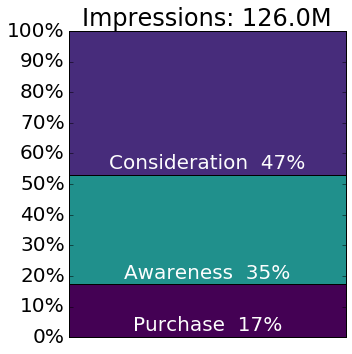

In [428]:
# Data slice:
dfplt = dgsl.copy()
dfplt = dfplt[['funnel_type','impressions']].groupby('funnel_type').sum()
dfplt['imppct'] = 100 * dfplt.impressions / dfplt.impressions.sum()
dfplt.sort_values('impressions', inplace = True)
dfplt.reset_index(inplace = True)
# Plot:
fig, ax = plt.subplots(1, 1, figsize = (5,5))
M = len(dfplt.imppct)
for idx in range(M):
    if idx == 0:
        ax.bar([0.5], dfplt.imppct[idx], 1, color = colorseq[idx], label = dfplt.funnel_type[idx])
        ax.text(1, 2, dfplt.funnel_type[idx] +'  '+ str(int(dfplt.imppct[idx]))+'%', fontsize = 20, color = 'white', ha = 'center')
    else:
        baseline = dfplt.imppct[0:idx].sum()
        ax.bar([0.5], dfplt.imppct[idx], 1, bottom = baseline, color = colorseq[idx], label = dfplt.funnel_type[idx])
        ax.text(1, baseline+2, dfplt.funnel_type[idx] +'  '+ str(int(dfplt.imppct[idx]))+'%', fontsize = 20, color = 'white', ha = 'center')

ax.set_ylim((0,100))
ax.set_xlim((0.5,1.5))
ax.set_title('Impressions: %sM' % round(dfplt.impressions.sum()/10**6,0), fontsize = 24)
fatlabels(ax, font_size = 20)
ax.yaxis.set_ticks(np.arange(0,101,10))
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.0f%%'))
ax.xaxis.set_ticks([])
plt.tight_layout()
plt.savefig('charts/Advertiser_creative_funnelimps.eps')

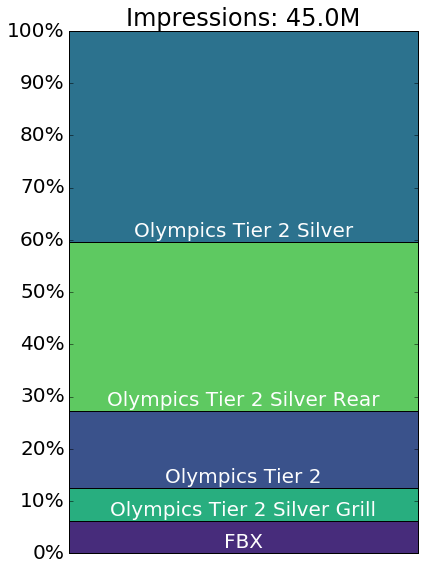

In [352]:
# Data slice:
dfplt = dgsl.query('funnel_type == "Awareness"')
dfplt = dfplt[['creative_type','impressions']].groupby('creative_type').sum()
dfplt['imppct'] = 100 * dfplt.impressions / dfplt.impressions.sum()
dfplt.sort_values('impressions', inplace = True)
dfplt.reset_index(inplace = True)
# Plot:
fig, ax = plt.subplots(1, 1, figsize = (6,8))
M = len(dfplt.imppct)
for idx in range(M):
    if idx == 0:
        ax.bar([0.5], dfplt.imppct[idx], 1, color = colorseq[idx], label = dfplt.creative_type[idx])
    else:
        baseline = dfplt.imppct[0:idx].sum()
        ax.bar([0.5], dfplt.imppct[idx], 1, bottom = baseline, color = colorseq[idx], label = dfplt.creative_type[idx])
        if baseline > 0.00001:
            ax.text(1, baseline+1, dfplt.creative_type[idx], fontsize = 20, color = 'white', ha = 'center')

ax.set_ylim((0,100))
ax.set_xlim((0.5,1.5))
ax.set_title('Impressions: %sM' % round(dfplt.impressions.sum()/10**6,0), fontsize = 24)
fatlabels(ax, font_size = 20)
ax.yaxis.set_ticks(np.arange(0,101,10))
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.0f%%'))
ax.xaxis.set_ticks([])
plt.tight_layout()
plt.savefig('charts/Advertiser_creative_awareness_imps.eps')

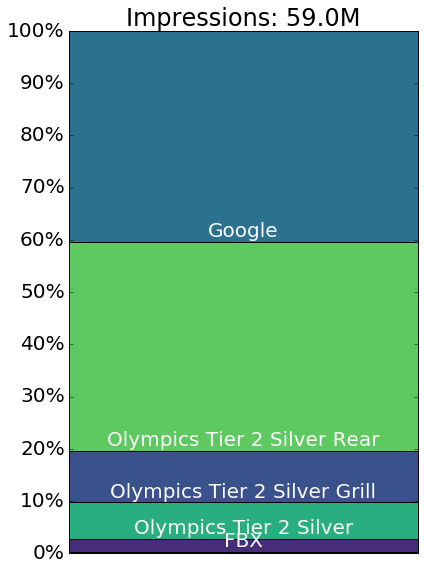

In [410]:
# Data slice:
dfplt = dgsl.query('funnel_type == "Consideration"')
dfplt = dfplt[['creative_type','impressions']].groupby('creative_type').sum()
dfplt['imppct'] = 100 * dfplt.impressions / dfplt.impressions.sum()
dfplt.sort_values('impressions', inplace = True)
dfplt.reset_index(inplace = True)
# Plot:
fig, ax = plt.subplots(1, 1, figsize = (6,8))
M = len(dfplt.imppct)
for idx in range(M):
    if idx == 0:
        ax.bar([0.5], dfplt.imppct[idx], 1, color = colorseq[idx], label = dfplt.creative_type[idx])
    else:
        baseline = dfplt.imppct[0:idx].sum()
        ax.bar([0.5], dfplt.imppct[idx], 1, bottom = baseline, color = colorseq[idx], label = dfplt.creative_type[idx])
        if baseline > 10**-4:
            ax.text(1, baseline+1, dfplt.creative_type[idx], fontsize = 20, color = 'white', ha = 'center')

ax.set_ylim((0,100))
ax.set_xlim((0.5,1.5))
ax.set_title('Impressions: %sM' % round(dfplt.impressions.sum()/10**6,0), fontsize = 24)
fatlabels(ax, font_size = 20)
ax.yaxis.set_ticks(np.arange(0,101,10))
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.0f%%'))
ax.xaxis.set_ticks([])
plt.tight_layout()
plt.savefig('charts/Advertiser_creative_consideration_imps.eps')

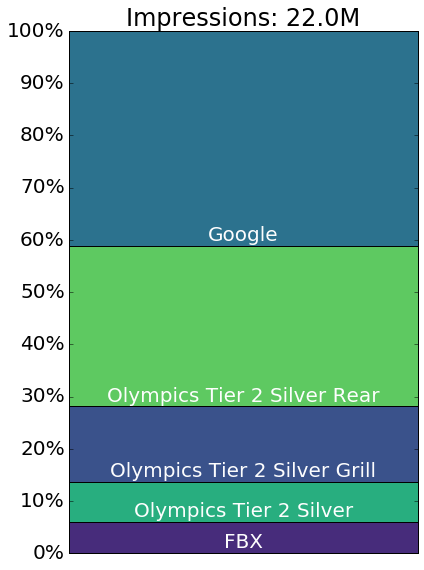

In [407]:
# Data slice:
dfplt = dgsl.query('funnel_type == "Purchase"')
dfplt = dfplt[['creative_type','impressions']].groupby('creative_type').sum()
dfplt['imppct'] = 100 * dfplt.impressions / dfplt.impressions.sum()
dfplt.sort_values('impressions', inplace = True)
dfplt.reset_index(inplace = True)
# Plot:
fig, ax = plt.subplots(1, 1, figsize = (6,8))
M = len(dfplt.imppct)
for idx in range(M):
    if idx == 0:
        ax.bar([0.5], dfplt.imppct[idx], 1, color = colorseq[idx], label = dfplt.creative_type[idx])
    else:
        baseline = dfplt.imppct[0:idx].sum()
        ax.bar([0.5], dfplt.imppct[idx], 1, bottom = baseline, color = colorseq[idx], label = dfplt.creative_type[idx])
        if baseline > 10**-9:
            ax.text(1, baseline+1, dfplt.creative_type[idx], fontsize = 20, color = 'white', ha = 'center')

ax.set_ylim((0,100))
ax.set_xlim((0.5,1.5))
ax.set_title('Impressions: %sM' % round(dfplt.impressions.sum()/10**6,0), fontsize = 24)
fatlabels(ax, font_size = 20)
ax.yaxis.set_ticks(np.arange(0,101,10))
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.0f%%'))
ax.xaxis.set_ticks([])
plt.tight_layout()
plt.savefig('charts/Advertiser_creative_purchase_imps.eps')

---
## Rich Media
---

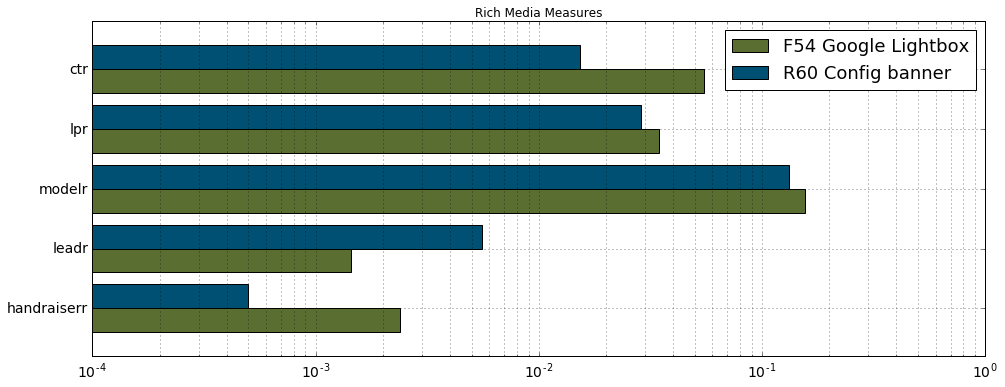

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (16,6))
wid = 0.4
cols = list(reversed(range(8,13)))
ind = np.arange(1,len(cols)+1)
ax.barh(ind, richmedia1.ix[0,cols], wid, label = richmedia1.ix[0,0], color = '#5A6E32')
ax.barh(ind + wid, richmedia1.ix[1,cols], wid, label = richmedia1.ix[1,0], color = '#005073')
ax.set(yticks = ind + wid, yticklabels = richmedia1.columns[cols], ylim = (1-wid, len(cols)+3*wid))
ax.legend(loc='upper right', fontsize = 18)
fatlabels(ax)
ax.set_xscale('log')
ax.grid(which = 'both')
ax.set_title('Rich Media Measures');

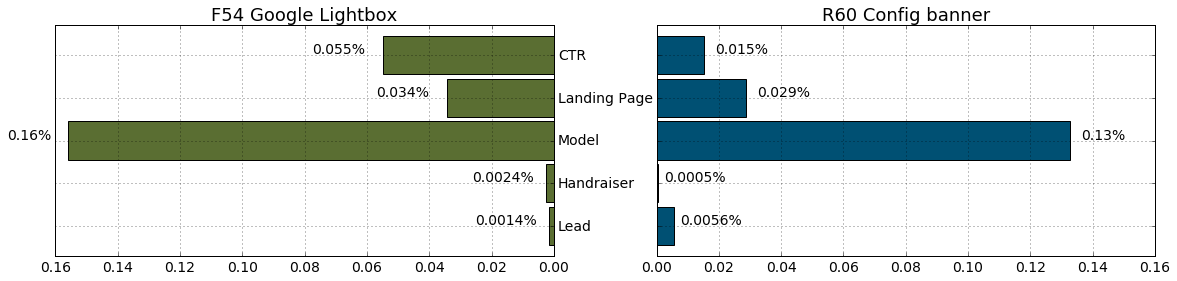

In [50]:
df2plot = richmedia1.ix[:, [0,8,9,10,12,11]]
fig, ax = plt.subplots(ncols = 2, figsize = (16,4), sharey=True)
wid = 0.9
marg = 0.2
#yticklabels = richmedia.columns[cols]
yticklabels = reversed(('CTR','Landing Page', 'Model', 'Handraiser', 'Lead'))
cols = list(reversed(range(1,6)))
ind = np.arange(1,len(cols)+1)
bars0 = ax[0].barh(ind, df2plot.ix[0,cols], wid, label = df2plot.ix[0,0], color = '#5A6E32', align='center')
bars1 = ax[1].barh(ind, df2plot.ix[1,cols], wid, label = df2plot.ix[1,0], color = '#005073', align='center')
bars = (bars0, bars1)
ax[0].set(yticks = ind, yticklabels = yticklabels, ylim = (1-wid, len(cols)+3*wid))
ax[1].set(yticks = ind, ylim = (1-wid+marg, len(cols)+wid-marg))
ax[0].yaxis.tick_right()
for idx in (0,1):
    #ax[idx].margins(0.01)
    fatlabels(ax[idx])
    ax[idx].grid()
    ax[idx].set_xlim((0,0.16))
    #ax[idx].set_xscale('log')
    barlabel_h(bars[idx], ax[idx])
    ax[idx].set_title(df2plot.ix[idx,0], fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(wspace=0.206)
ax[0].invert_xaxis()
plt.savefig('Advertiser_creative.png', bbox_inches='tight', dpi = 600)

---
Are the landing page rates meaningful with this weird counting?

In [ ]:
richmedia1

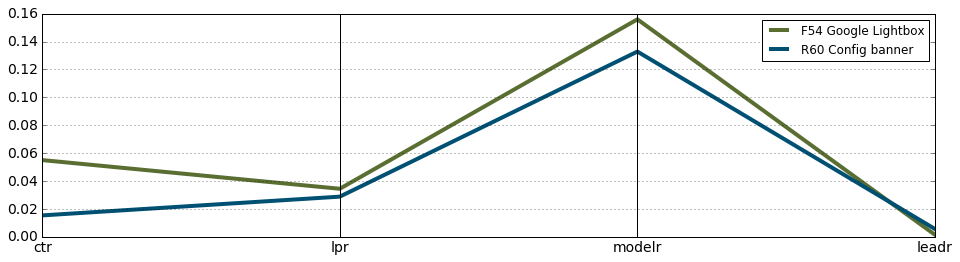

In [51]:
fig = plt.figure(figsize = (16,4))
ax = pd.tools.plotting.parallel_coordinates(richmedia1, 'creative_type', cols = ['ctr','lpr','modelr','leadr'], lw = 4, color = ('#5A6E32','#005073'))
fatlabels(ax)

In [52]:
f54_imps = richmedia1.impressions[0]
r60_imps = richmedia1.impressions[1]

In [53]:
dg2 = pd.DataFrame(dgrmsl.groupby(['creative_type', 'rich_media_event']).sum().ix[:,('interactions')])
dg2.drop('(not set)', level = 1, inplace = True)
dg2['impressions'] = 0
dg2.ix['F54 Google Lightbox', :].impressions = f54_imps
dg2.ix['R60 Config banner', :].impressions = r60_imps
dg2['interactionr'] = dg2.interactions / dg2.impressions
dg2.drop(['impressions','interactions'], axis = 1, inplace = True)
dg2.sort_values('interactionr', inplace = True, ascending = False)
dg2.fillna(0, inplace = True)
dg2.head(2)

interactionr
creative_type       rich_media_event                                  
F54 Google Lightbox Counter : Collapse_Desktop_Served         0.348767
                    Counter : Collapse_Video_Progress_0%      0.281976

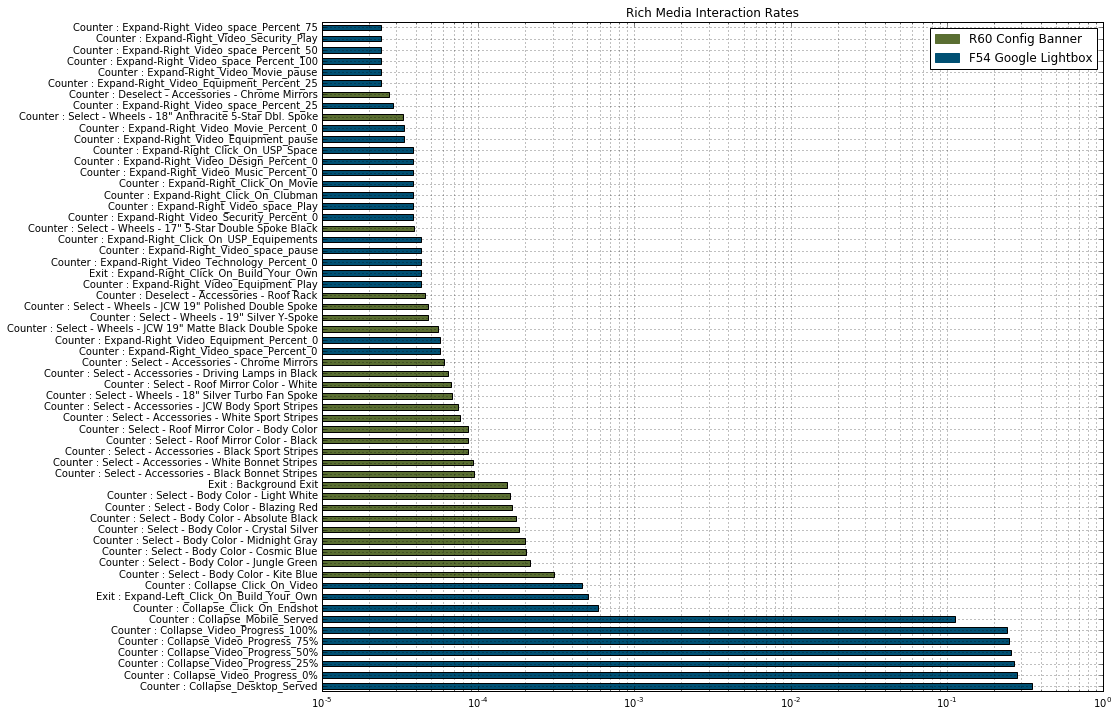

In [54]:
nbars = 60
fig, ax = plt.subplots(1, 1, figsize = (14,12))
df2plot = dg2.head(nbars).reset_index()
bar_colors = df2plot.creative_type.str.contains('F54').apply(lambda x: '#005073' if x else '#5A6E32')
df2plot.interactionr.plot.barh(ax = ax, color = bar_colors)
ax.set_yticklabels(df2plot.rich_media_event[:nbars])
ax.set_xscale('log')
ax.set_title('Rich Media Interaction Rates')
ax.legend(handles = [mpl.patches.Patch(color = '#5A6E32', label = 'R60 Config Banner'),
                     mpl.patches.Patch(color = '#005073', label = 'F54 Google Lightbox')])
ax.grid(which = 'both')

In [55]:
dg3 = pd.DataFrame(dgrmsl.groupby(['creative_type', 'rich_media_cat']).sum().ix[:,('interactions')])
dg3.drop('(not set)', level = 1, inplace = True)
dg3['impressions'] = 0
dg3.ix['F54 Google Lightbox', :].impressions = f54_imps
dg3.ix['R60 Config banner', :].impressions = r60_imps
dg3['interactionr'] = dg3.interactions / dg3.impressions
dg3.drop(['impressions','interactions'], axis = 1, inplace = True)
dg3.sort_values('interactionr', inplace = True, ascending = False)
dg3.fillna(0, inplace = True)
dg3.head(2)

interactionr
creative_type       rich_media_cat              
F54 Google Lightbox Collapse             1.76104
                    Expand               0.00197

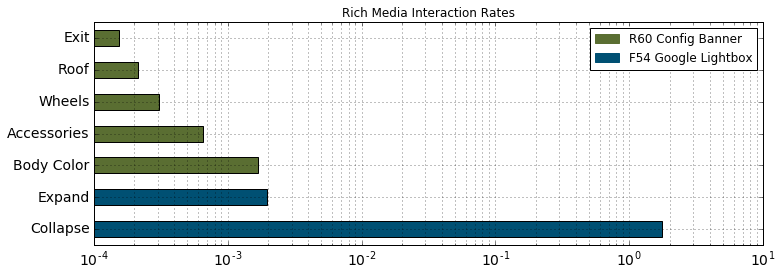

In [56]:
nbars = 100
fig, ax = plt.subplots(1, 1, figsize = (12,4))
df3plot = dg3.head(nbars).reset_index()
bar_colors = df3plot.creative_type.str.contains('F54').apply(lambda x: '#005073' if x else '#5A6E32')
df3plot.interactionr.plot.barh(ax = ax, color = bar_colors)
ax.set_yticklabels(df3plot.rich_media_cat[:nbars])
ax.set_xscale('log')
ax.set_title('Rich Media Interaction Rates')
ax.legend(handles = [mpl.patches.Patch(color = '#5A6E32', label = 'R60 Config Banner'),
                     mpl.patches.Patch(color = '#005073', label = 'F54 Google Lightbox')])
fatlabels(ax)
ax.grid(which = 'both')

In [57]:
dgrmsl.head(1)

,date,campaign_id,campaign,site_dcm,placement,creative_id,creative,creative_type_dfa,rich_media_event,activity_id,...,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model,rich_media_cat
509156,2016-06-07,9373920,Advertiser 2016 - Tier 1 Foundational,Cadreon,Cadreon|CPM|RON|RT|A25-54|FT|T1_Q2_Retargeting...,71112830,Countryman Config Banner 160x600 (Non-Expanding),Rich Media display banner,(not set),(not set),...,,,,0,0,0,0,0,0,(not set)


In [58]:
dgrmsl.pivot_table(index = 'creative_type', values = ['impressions','clicks','interactions','manual_closes','total_display_time','expansions','rich_media_clicks'],
    aggfunc = np.sum, margins = False, dropna = False, fill_value = 0).style.bar(color = '#99ff33')

In [59]:
dgrmsl.pivot_table(index = 'creative_type', values = ['lp_f54','lp_r60'],
    aggfunc = np.sum, margins = False, dropna = False, fill_value = 0).style.bar(color = '#00AAFF')

In [60]:
richmedia2 = dgrmsl.pivot_table(index = 'creative_type', values = ['impressions','expansions','manual_closes','total_display_time'], aggfunc = np.sum, fill_value = 0)
richmedia2.reset_index(inplace = True)
richmedia2['expansionr'] = 100 * richmedia2.expansions / richmedia2.impressions
richmedia2['closer'] = 100 * richmedia2.manual_closes / richmedia2.impressions
richmedia2['avgtotaltime'] = richmedia2.total_display_time / richmedia2.impressions
richmedia2

,creative_type,expansions,impressions,manual_closes,total_display_time,expansionr,closer,avgtotaltime
0,F54 Google Lightbox,127,209131,24,9960559,0.060727,0.011476,47.628324
1,R60 Config banner,0,1003902,0,69290740,0.000000,0.000000,69.021418


In [61]:
# May error, launch in June similar 2016 F57 campaign convertible config banner non-expanding.

In [62]:
richmedia = richmedia2.merge(richmedia1, on = 'creative_type')
richmedia.round(5)

,creative_type,expansions,impressions_x,manual_closes,total_display_time,expansionr,closer,avgtotaltime,clicks,handraiser,impressions_y,lead,lp_f54,lp_r60,model,ctr,lpr,modelr,leadr,handraiserr
0,F54 Google Lightbox,127,209131,24,9960559,0.06073,0.01148,47.62832,115,5,209131,3,72,96,326,0.05499,0.03443,0.15588,0.00143,0.00239
1,R60 Config banner,0,1003902,0,69290740,0.00000,0.00000,69.02142,154,5,1003902,56,278,289,1333,0.01534,0.02879,0.13278,0.00558,0.00050


In [64]:
dgrmsl.head(1)

,date,campaign_id,campaign,site_dcm,placement,creative_id,creative,creative_type_dfa,rich_media_event,activity_id,...,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model,rich_media_cat
509156,2016-06-07,9373920,Advertiser 2016 - Tier 1 Foundational,Cadreon,Cadreon|CPM|RON|RT|A25-54|FT|T1_Q2_Retargeting...,71112830,Countryman Config Banner 160x600 (Non-Expanding),Rich Media display banner,(not set),(not set),...,,,,0,0,0,0,0,0,(not set)


In [65]:
dgrmsl.pivot_table(index = 'creative_type', values = ['impressions','clicks','interactions','manual_closes','total_display_time','expansions','rich_media_clicks'],
    aggfunc = np.sum, margins = False, dropna = False, fill_value = 0).style.bar(color = '#99ff33')

---
### R60 Config Banner vs B:

In [66]:
dgrms2 = dgrm.query('date >= "2016-06-01" and date <= "2016-08-31"')
dgrms2.rename(columns = {'total_interactions':'interactions'}, inplace = True)
dgrms2 = dgrms2[dgrms2.campaign.isin(['Advertiser 2016 - Tier 1 Foundational','Advertiser 2016 - F57'])]
dgrms2 = dgrms2[dgrms2.creative_type_dfa.str.startswith('Rich Media')]
dgrms2 = dgrms2[dgrms2.creative.str.startswith('Co')]
dgrms2.creative_type = dgrms2.creative.str.lower()
dgrms2.creative_type = dgrms2.creative_type.apply(lambda x: 'Countryman' if 'countryman' in x else x)
dgrms2.creative_type = dgrms2.creative_type.apply(lambda x: 'Convertible' if 'convertible' in x else x)
dgrms2['rich_media_cat1'] = dgrms2.rich_media_event.str.lower()
dgrms2.rich_media_cat1 = dgrms2.rich_media_cat1.apply(lambda x: 'Wheels' if 'wheels' in x else x)
dgrms2.rich_media_cat1 = dgrms2.rich_media_cat1.apply(lambda x: 'Body Color' if 'body color' in x else x)
dgrms2.rich_media_cat1 = dgrms2.rich_media_cat1.apply(lambda x: 'Roof' if 'roof' in x else x)
dgrms2.rich_media_cat1 = dgrms2.rich_media_cat1.apply(lambda x: 'Accessories' if 'accessories' in x else x)
dgrms2.rich_media_cat1 = dgrms2.rich_media_cat1.apply(lambda x: 'Mirror Color' if 'mirror' in x else x)
dgrms2.rich_media_cat1 = dgrms2.rich_media_cat1.apply(lambda x: 'Exit' if 'exit' in x else x)
dgrms2.rename(columns = {'total_interactions':'interactions'}, inplace = True)
dgrms2.head(1)

,date,campaign_id,campaign,site_dcm,placement,creative_id,creative,creative_type_dfa,rich_media_event,activity_id,...,act_type2,act_type3,act_type4,lead,handraiser,lp_f54,lp_f57,lp_r60,model,rich_media_cat1
469873,2016-06-01,9703514,Advertiser 2016 - F57,Cadreon,Cadreon|CPM|RON|BT|A40-64|FT|F57_Behavioral_Li...,71116253,Convertible Config Banner 728x90 (Non-Expanding),Rich Media display banner,(not set),2483003,...,,,,0,0,0,0,0,0,(not set)


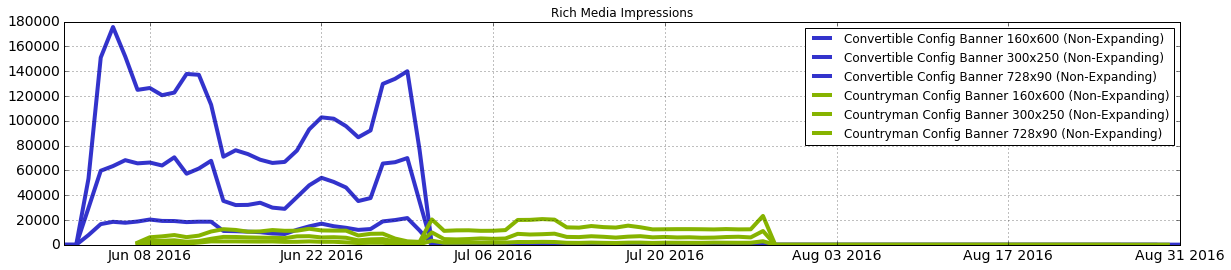

In [69]:
fig, ax = plt.subplots(1, 1, figsize = (20,4))
tser = dgrms2.groupby(['date','creative']).impressions.sum().reset_index().set_index('date')
def colorfunc(cr):
    return '#3333cc' if 'Convertible' in cr else '#86b300'
for cr in tser.creative.unique():
    ax.plot(tser[tser.creative == cr].impressions, label = cr, lw = 4, color = colorfunc(cr))
#ax.set_yscale('log')
ax.set_title('Rich Media Impressions')
fatlabels(ax)
ax.legend()
ax.grid(which = 'both')

In [70]:
dgrms2.creative_type.unique()

array(['Convertible', 'Countryman'], dtype=object)

In [71]:
dg4 = pd.DataFrame(dgrms2.groupby(['creative_type', 'rich_media_event']).sum().ix[:,('interactions')])
dg4.drop('(not set)', level = 1, inplace = True)
dg4['impressions'] = 0
dg4.ix['Convertible', :].impressions = dgrms2.groupby(['creative_type']).sum().ix['Convertible',('impressions')]
dg4.ix['Countryman', :].impressions = dgrms2.groupby(['creative_type']).sum().ix['Countryman',('impressions')]
dg4['interactionr'] = dg4.interactions / dg4.impressions
dg4.drop(['impressions','interactions'], axis = 1, inplace = True)
dg4.sort_values('interactionr', inplace = True, ascending = False)
dg4.fillna(0, inplace = True)
dg4.head(6)

interactionr
creative_type rich_media_event                                                
Convertible   Counter : Select - Body Color - Blazing Red             0.000305
Countryman    Counter : Select - Body Color - Kite Blue               0.000305
Convertible   Counter : Select - Body Color - British Racing ...      0.000235
              Counter : Select - Body Color - Thunder Grey            0.000228
              Counter : Select - Body Color - Melting Silver          0.000224
              Counter : Select - Body Color - Moonwalk Grey           0.000217

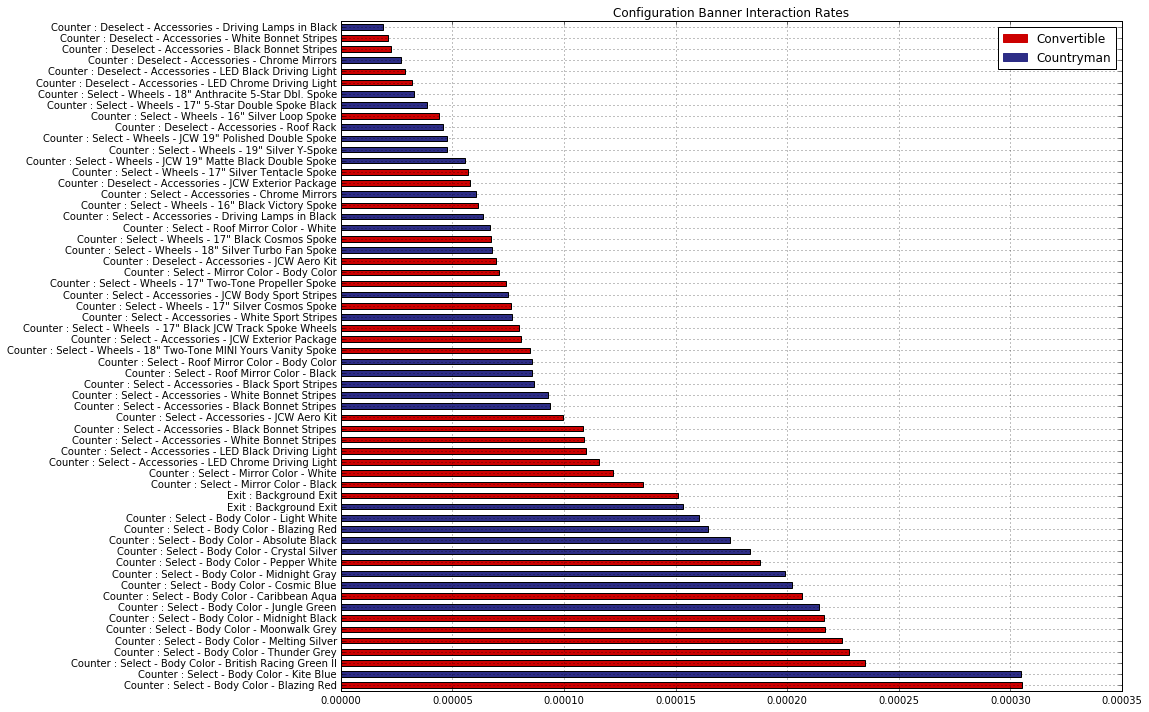

In [72]:
nbars = 60
fig, ax = plt.subplots(1, 1, figsize = (14,12))
dg4plot = dg4.head(nbars).reset_index()
bar_colors = dg4plot.creative_type.str.contains('Convertible').apply(lambda x: '#cc0000' if x else '#2d2d86')
dg4plot.interactionr.plot.barh(ax = ax, color = bar_colors)
ax.set_yticklabels(dg4plot.rich_media_event[:nbars])
#ax.set_xscale('log')
ax.set_title('Configuration Banner Interaction Rates')
ax.legend(handles = [mpl.patches.Patch(color = '#cc0000', label = 'Convertible'),
                     mpl.patches.Patch(color = '#2d2d86', label = 'Countryman')])
ax.grid(which = 'both')

In [73]:
dg5 = pd.DataFrame(dgrms2.groupby(['rich_media_cat1','creative_type','rich_media_event']).sum().ix[:,('interactions')])
dg5.drop('(not set)', level = 0, inplace = True)
dg5['impressions'] = 0
#dg5.ix['Convertible', :].impressions = dgrms2.groupby(['creative_type']).sum().ix['Convertible',('impressions')]
#dg5.ix['Countryman', :].impressions = dgrms2.groupby(['creative_type']).sum().ix['Countryman',('impressions')]
#dg5['interactionr'] = dg5.interactions / dg5.impressions
#dg5.drop(['impressions','interactions'], axis = 1, inplace = True)
#dg5.sort_values('interactionr', inplace = True, ascending = False)
#dg5.fillna(0, inplace = True)
dg5#.style.bar(color = '#00AAFF')

interactions  \
rich_media_cat1 creative_type rich_media_event                                                   
Accessories     Convertible   Counter : Deselect - Accessories - Black Bonnet...           109   
                              Counter : Deselect - Accessories - JCW Aero Kit              333   
                              Counter : Deselect - Accessories - JCW Exterior...           278   
                              Counter : Deselect - Accessories - LED Black Dr...           138   
                              Counter : Deselect - Accessories - LED Chrome D...           153   
                              Counter : Deselect - Accessories - White Bonnet...           102   
                              Counter : Select - Accessories - Black Bonnet S...           521   
                              Counter : Select - Accessories - JCW Aero Kit                479   
                              Counter : Select - Accessories - JCW Exterior P...           387   
                              Counter : Select - Accessories - LED Black Driv...           528   
                              Counter : Select - Accessories - LED Chrome Dri...           555   
                              Counter : Select - Accessories - White Bonnet S...           524   
                Countryman    Counter : Deselect - Accessories - Black Bonnet...            10   
                              Counter : Deselect - Accessories - Black Sport ...            13   
                              Counter : Deselect - Accessories - Chrome Mirrors             27   
                              Counter : Deselect - Accessories - Driving Lamp...            19   
                              Counter : Deselect - Accessories - JCW Body Spo...            11   
                              Counter : Deselect - Accessories - White Bonnet...            13   
                              Counter : Deselect - Accessories - White Sport ...             9   
                              Counter : Select - Accessories - Black Bonnet S...            94   
                              Counter : Select - Accessories - Black Sport St...            87   
                              Counter : Select - Accessories - Chrome Mirrors               61   
                              Counter : Select - Accessories - Driving Lamps ...            64   
                              Counter : Select - Accessories - JCW Body Sport...            75   
                              Counter : Select - Accessories - White Bonnet S...            93   
                              Counter : Select - Accessories - White Sport St...            77   
Body Color      Convertible   Counter : Select - Body Color - Blazing Red                 1466   
                              Counter : Select - Body Color - British Racing ...          1129   
                              Counter : Select - Body Color - Caribbean Aqua               993   
                              Counter : Select - Body Color - Melting Silver              1078   
...                                                                                        ...   
                Countryman    Counter : Select - Body Color - Cosmic Blue                  203   
                              Counter : Select - Body Color - Crystal Silver               184   
                              Counter : Select - Body Color - Jungle Green                 215   
                              Counter : Select - Body Color - Kite Blue                    306   
                              Counter : Select - Body Color - Light White                  161   
                              Counter : Select - Body Color - Midnight Gray                200   
                              Counter : Select - Roof Mirror Color - Body Color             86   
Exit            Convertible   Exit : Background Exit                                       725   
                Countryman    Exit : Background Exit            

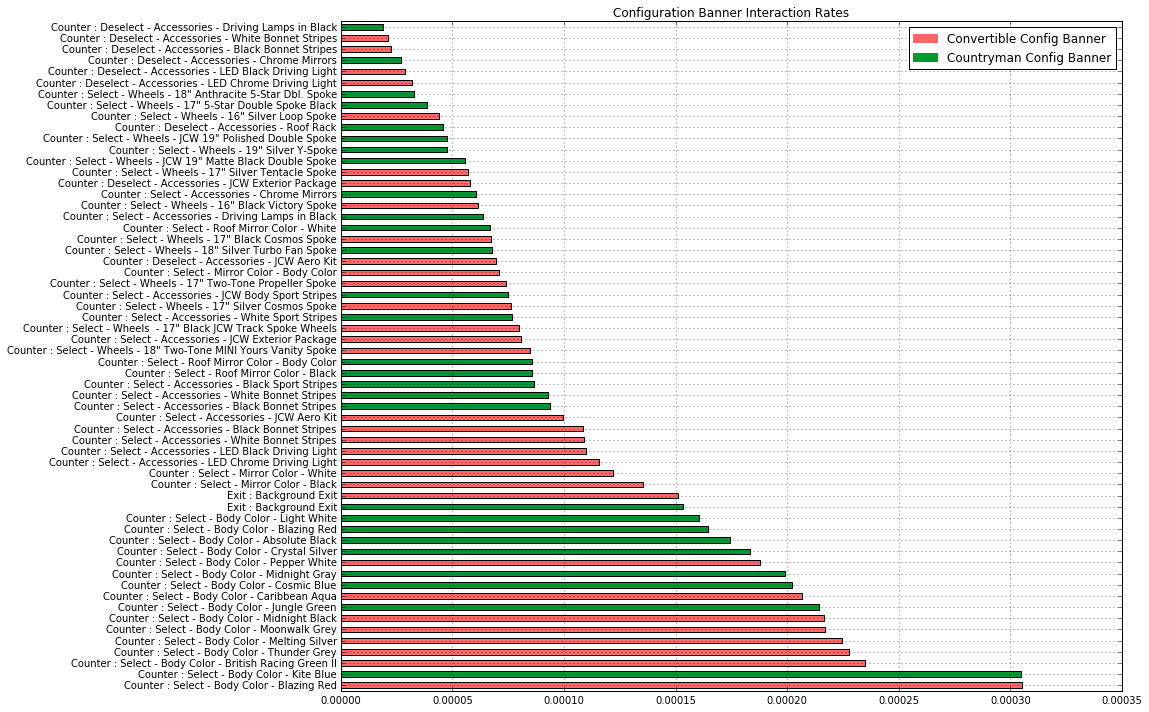

In [74]:
nbars = 60
fig, ax = plt.subplots(1, 1, figsize = (14,12))
dg4plot = dg4.head(nbars).reset_index()
bar_colors = dg4plot.creative_type.str.contains('Convertible').apply(lambda x: '#ff6666' if x else '#009933')
dg4plot.interactionr.plot.barh(ax = ax, color = bar_colors)
ax.set_yticklabels(dg4plot.rich_media_event[:nbars])
#ax.set_xscale('log')
ax.set_title('Configuration Banner Interaction Rates')
ax.legend(handles = [mpl.patches.Patch(color = '#ff6666', label = 'Convertible Config Banner'),
                     mpl.patches.Patch(color = '#009933', label = 'Countryman Config Banner')])
ax.grid(which = 'both')

In [ ]:
## Add handraiser rate to current...